In [1]:
import subprocess
subprocess.run(['sudo','cpupower','frequency-set','-u','6.0Ghz'],stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL)

CompletedProcess(args=['sudo', 'cpupower', 'frequency-set', '-u', '6.0Ghz'], returncode=0)

In [2]:
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/Arannamoy/datasets/refs/heads/main/Medical%20Cost%20Personal%20Datasets/insurance.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
train_df,test_df=train_test_split(df,test_size=0.25,random_state=42)

In [6]:
label_encoder={}
categorical_cols=['sex','smoker','region']
for col in categorical_cols:
    le=LabelEncoder()
    train_df[col]=le.fit_transform(train_df[col])
    test_df[col]=le.transform(test_df[col])

In [7]:
train_df.head(5)

,age,sex,bmi,children,smoker,region,charges
693,24,1,23.655,0,0,1,2352.96845
1297,28,0,26.510,2,0,2,4340.44090
634,51,1,39.700,1,0,3,9391.34600
1022,47,1,36.080,1,1,2,42211.13820
178,46,0,28.900,2,0,3,8823.27900


In [8]:
X_train=train_df.drop(columns=['charges'])
y_train=train_df['charges']
X_test=test_df.drop(columns=['charges'])
y_test=test_df['charges']

In [9]:
X_train.head(1)

,age,sex,bmi,children,smoker,region
693,24,1,23.655,0,0,1


In [10]:
y_train.head(1)

693    2352.96845
Name: charges, dtype: float64

In [11]:
scaler=StandardScaler()
X_train_scaler=scaler.fit_transform(X_train)
X_test_scaler=scaler.transform(X_test)

In [12]:
class InsuranceDateset(Dataset):
    def __init__(self,X_train,y_train):
        super(InsuranceDateset,self).__init__()
        self.X_train=X_train
        self.y_train=y_train
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, index):
        features=torch.tensor(self.X_train[index],dtype=torch.float32)
        target=torch.tensor(self.y_train.values[index],dtype=torch.float32)
        return features,target

In [13]:
dataset=InsuranceDateset(X_train_scaler,y_train)

In [14]:
dataloader=DataLoader(dataset,batch_size=320,shuffle=True)

In [15]:
for batch_index,(features,targets) in enumerate(dataloader):
    print(f"Batch {batch_index+1}:")
    print(f"Features: {features.shape}")
    print(f"Tragets {targets.shape}")
    


Batch 1:
Features: torch.Size([320, 6])
Tragets torch.Size([320])
Batch 2:
Features: torch.Size([320, 6])
Tragets torch.Size([320])
Batch 3:
Features: torch.Size([320, 6])
Tragets torch.Size([320])
Batch 4:
Features: torch.Size([43, 6])
Tragets torch.Size([43])


In [16]:
import torch.nn as nn

In [17]:
class SimpleLinearRegression(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(SimpleLinearRegression,self).__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size),
            nn.ReLU(),
            nn.Linear(output_size,1)
        )
    
    def forward(self,x):
        return self.network(x)

In [18]:
model=SimpleLinearRegression(X_train.shape[1],64,128)

In [19]:
import torch.optim as optim

In [20]:
criterion=nn.MSELoss()
lr=0.001
optimizer=optim.Adam(model.parameters(),lr)

In [21]:
epochs=5000

X_train_tensor=torch.tensor(X_train_scaler,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32).view(-1,1)
X_test_tensor=torch.tensor(X_test_scaler,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32).view(-1,1)

training_losses=[]
validity_losses=[]

for epoch in range(epochs):
    model.train()
    for batch_index,(batch_X,batch_y) in enumerate(dataloader):
        # print(f"Current batch index: {batch_index}") 
        optimizer.zero_grad()
        result=model(batch_X)
        train_loss=criterion(result,batch_y)
        train_loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        y_pred=model(X_test_tensor)
        validity_loss=criterion(y_pred,y_test_tensor)
    if (epoch+1)%100 ==0:
        training_losses.append(train_loss.item())
        validity_losses.append(validity_loss.item())
    if (epoch+1)%1000==0:
        print(f"Epoch {epoch}/{epochs}, Loss: {train_loss.item()}")

/home/test-14900/anaconda3/envs/conda-env-3-11/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/test-14900/anaconda3/envs/conda-env-3-11/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 999/5000, Loss: 113224056.0
Epoch 1999/5000, Loss: 259406976.0
Epoch 2999/5000, Loss: 157156416.0
Epoch 3999/5000, Loss: 166278320.0
Epoch 4999/5000, Loss: 140331968.0


In [22]:
import matplotlib.pyplot as plt

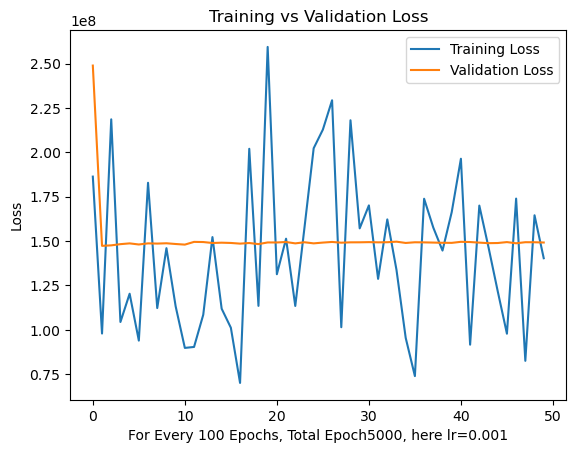

In [23]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validity_losses, label='Validation Loss')
plt.xlabel(f'For Every 100 Epochs, Total Epoch{epochs}, here lr={lr}')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [24]:
subprocess.run(['sudo','cpupower','frequency-set','-u','2.8Ghz'],stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL)

CompletedProcess(args=['sudo', 'cpupower', 'frequency-set', '-u', '2.8Ghz'], returncode=0)